In [1]:
# import classy module
import chaospy
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import ElNetFortran
import euclidemu2 as ee2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
from scipy.optimize import fsolve
from scipy.interpolate import CubicSpline
import time
import math
import numpoly
from scipy.fft import fft, dct
from scipy import integrate
from scipy import interpolate
from scipy.fftpack import dst, idst
from scipy.integrate import simps
from scipy.integrate import trapz


Classy could not be found in your system.
Here are some suggestions:

	 -Download the Class from class-code.net and install it
	  together with its wrapper classy (type 'make' instead of
	  'make class'
	 -If you know that Class is installed on your system
	  and yet classy could not be installed, try re-compiling
	  Class with just ''make'' instead of ''make class''
NOTICE: Even without classy you can still use EuclidEmulator2
        to emulate boost factors. You won't be able to compute
        full power spectra, though.


In [20]:
from tqdm.notebook import trange, tqdm
from hyperopt import tpe, hp, fmin,atpe


In [21]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 150
rcParams["font.size"] = 10

In [2]:
def smooth_bao(ks, pk):
    
 
    
    n = 15
    dst_ks = np.linspace(1e-4, 5, 2**n) #10
    logks = np.log(dst_ks)
    
    
    spline_loglog_pk_2 = interpolate.interp1d(np.log(ks), np.log(pk), kind='linear', fill_value='extrapolate')
    spline_loglog_pk2 = spline_loglog_pk_2(np.log(np.linspace(1e-4, 5, 2**n)))
    
    spline_loglog_pk = interpolate.splrep(np.log(np.linspace(1e-4,5, 2**n)), spline_loglog_pk2, s=0)    
        
    logkpk = np.log10(dst_ks * np.exp(interpolate.splev(np.log(dst_ks), spline_loglog_pk, der=0, ext=0)))
    sine_transf_logkpk = dst(logkpk, type=2)# dst(logkpk, type=2, norm='ortho')
    odds = [] # odd entries
    evens = [] # even entries
    even_is = [] # odd indices
    odd_is = [] # even indices
    all_is = [] # all indices
    for i, entry in enumerate(sine_transf_logkpk):
        all_is.append(i)
        if i%2 == 0:
            even_is.append(i)
            evens.append(entry)
        else:
            odd_is.append(i)
            odds.append(entry)

    odds=np.array(odds)
    evens=np.array(evens)
 

    odd_is = np.array(odd_is)
    even_is = np.array(even_is)
    
    
    odds_interp = interpolate.splrep(odd_is, odds, s=0) 
    evens_interp = interpolate.splrep(even_is, evens, s=0) 
    

    
    
    d2_odds =interpolate.splev(odd_is, odds_interp, der=2, ext=0)    
    d2_evens =interpolate.splev(even_is, evens_interp, der=2, ext=0)
    
    
    
    d2_odds_1 =interpolate.splev(odd_is +2, odds_interp, der=2, ext=0) 
    d2_evens_1 =interpolate.splev(even_is +2, evens_interp, der=2, ext=0)
   


    d2_odds_2 =interpolate.splev(odd_is - 2, odds_interp, der=2, ext=0)
    d2_evens_2 =interpolate.splev(even_is - 2 , evens_interp, der=2, ext=0)
    
   
    
    
    
    d2_odds_avg = (d2_odds + d2_odds_2 + d2_odds_1)/3
  

    d2_evens_avg = (d2_evens + d2_evens_2 + d2_evens_1)/3 

    
    
    imin_even = 50+np.argmax(d2_evens_avg[50:150]) -9
    
    imax_even = 50+np.argmin(d2_evens_avg[50:150])+36

    imin_odd = 50+np.argmax(d2_odds_avg[50:150])-9

    imax_odd = 50+np.argmin(d2_odds_avg[50:150])+37

    
    
        
    
    even_is_removed_bumps = np.concatenate((even_is[:imin_even], even_is[imax_even:]))
    odd_is_removed_bumps = np.concatenate((odd_is[:imin_odd], odd_is[imax_odd:]))

    evens_removed_bumps = np.concatenate((evens[:imin_even], evens[imax_even:]))
    odds_removed_bumps = np.concatenate((odds[:imin_odd], odds[imax_odd:]))

    
     

    
    
 

    even_holed_cs = interpolate.splrep(even_is_removed_bumps, evens_removed_bumps * (even_is_removed_bumps+1)**2, s=0)
    odd_holed_cs = interpolate.splrep(odd_is_removed_bumps, odds_removed_bumps * (odd_is_removed_bumps+1)**2, s=0)
  
    
    evens_treated = interpolate.splev(even_is, even_holed_cs, der=0, ext=0) / (even_is + 1)**2
    odds_treated = interpolate.splev(odd_is, odd_holed_cs, der=0, ext=0) / (odd_is + 1)**2
    treated_transform = []
    for odd, even in zip(odds_treated, evens_treated):
        treated_transform.append(even)
        treated_transform.append(odd)
    treated_transform=np.array(treated_transform)    
    treated_logkpk =idst(treated_transform, type=2)/ (2 * len(treated_transform)) # idst(treated_transform, type=2, norm='ortho')
    pk_nw = 10**(treated_logkpk)/dst_ks
    
    k_highk = ks[ks > 4]
    p_highk = pk[ks > 4]

    k_extended = np.concatenate((dst_ks[dst_ks < 4], k_highk))
    
    p_extended = np.concatenate((pk_nw[dst_ks < 4], p_highk))
    

    pksmooth_cs = interpolate.splrep(np.log(k_extended), np.log(p_extended), s=0)
    pksmooth_interp = np.exp(interpolate.splev(np.log(ks), pksmooth_cs, der=0, ext=0))

    
    
        
   
    return pksmooth_interp#, d2_odds_avg, d2_evens_avg, odd_is,even_is, imin_odd,imax_odd, imin_even, imax_even, np.exp(interpolate.splev(np.log(dst_ks),spline_loglog_pk, der=0, ext=0)), dst_ks,np.argmax(d2_evens_avg[100:300]),np.argmin(d2_evens_avg[100:300]),np.argmax(d2_odds_avg[100:300]),np.argmin(d2_odds_avg[100:300]),spline_loglog_pk2
def smear_bao(ks, pk, pk_nw, par):
    from scipy.integrate import trapz

     
       
    integral = simps(pk,ks)#trapz(ks * pk, x=np.log(ks))  #simps(pk,ks)#
    k_star_inv = (1.0/(3.0 * np.pi**2)) * integral
    Gk = np.array([np.exp(-par*k_star_inv * (k_**2)) for k_ in ks])
    pk_smeared = pk*Gk + pk_nw*(1.0 - Gk)
    return pk_smeared

In [3]:
def _nowiggles_pk_(k_lin=None, pk_lin=None, k_emu=None):
    """De-wiggled linear prediction of the cold matter power spectrum

    The BAO feature is removed by identifying and removing its corresponding
    bump in real space, by means of a DST, and consequently transforming
    back to Fourier space.
    See:
    - Baumann et al 2018 (https://arxiv.org/pdf/1712.08067.pdf)
    - Giblin et al 2019 (https://arxiv.org/pdf/1906.02742.pdf)

    :param k_lin: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              camb are returned, defaults to None
    :type k_lin: array_like, optional
    :param pk_lin: a vector of linear power spectrum computed at k_lin, if None
              camb will be called, defaults to None
    :type pk_lin: array_like, optional

    :param k_emu: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              the emulator are returned, defaults to None
    :type k_emu: array_like, optional

    :return: dewiggled pk computed at k_emu
    :rtype: array_like
    """

    from scipy.fftpack import dst, idst

    nk = int(2**15)
    kmin = 1e-4
    kmax =  10
    klin = np.linspace(kmin, kmax, nk)

    pkcamb_cs = interpolate.splrep(np.log(k_lin), np.log(pk_lin), s=0)
    pklin = np.exp(interpolate.splev(np.log(klin), pkcamb_cs, der=0, ext=0))

    f = np.log10(klin * pklin)
 
    dstpk = dst(f, type=2, norm='ortho')
 
    even = dstpk[0::2]
    odd = dstpk[1::2]

    i_even = np.arange(len(even)).astype(int)
    i_odd = np.arange(len(odd)).astype(int)


    even_cs = interpolate.splrep(i_even, even, s=0)
    odd_cs = interpolate.splrep(i_odd, odd, s=0)
    
    
    

    even_2nd_der = interpolate.splev(i_even, even_cs, der=2, ext=0)
    odd_2nd_der = interpolate.splev(i_odd, odd_cs, der=2, ext=0)
    
    


    # [~1e-4, 10], any other choice would require visual inspection
    imin_even = i_even[100:300][np.argmax(even_2nd_der[100:300])] - 20
    imax_even = i_even[100:300][np.argmin(even_2nd_der[100:300])] + 70

    imin_odd = i_odd[100:300][np.argmax(odd_2nd_der[100:300])] - 20

    imax_odd = i_odd[100:300][np.argmin(odd_2nd_der[100:300])] + 75

    i_even_holed = np.concatenate((i_even[:imin_even], i_even[imax_even:]))
    i_odd_holed = np.concatenate((i_odd[:imin_odd], i_odd[imax_odd:]))

    even_holed = np.concatenate((even[:imin_even], even[imax_even:]))
    odd_holed = np.concatenate((odd[:imin_odd], odd[imax_odd:]))

    even_holed_cs = interpolate.splrep(i_even_holed, even_holed * (i_even_holed+1)**2, s=0)
    odd_holed_cs = interpolate.splrep(i_odd_holed, odd_holed * (i_odd_holed+1)**2, s=0)

    even_smooth = interpolate.splev(i_even, even_holed_cs, der=0, ext=0) / (i_even + 1)**2
    odd_smooth = interpolate.splev(i_odd, odd_holed_cs, der=0, ext=0) / (i_odd + 1)**2

    dstpk_smooth = []
    for ii in range(len(i_even)):
        dstpk_smooth.append(even_smooth[ii])
        dstpk_smooth.append(odd_smooth[ii])
    dstpk_smooth = np.array(dstpk_smooth)

    pksmooth = idst(dstpk_smooth, type=2, norm='ortho')# / (2 * len(dstpk_smooth))
    pksmooth = 10**(pksmooth) / klin

    k_highk = k_lin[k_lin > 5]
    p_highk = pk_lin[k_lin > 5]
  

    k_extended = np.concatenate((klin[klin < 5], k_highk))
    p_extended = np.concatenate((pksmooth[klin < 5], p_highk))

    pksmooth_cs = interpolate.splrep(np.log(k_extended), np.log(p_extended), s=0)
    pksmooth_interp = np.exp(interpolate.splev(np.log(k_emu), pksmooth_cs, der=0, ext=0))

    return pksmooth_interp#,even_2nd_der , imin_even,imax_even,odd_2nd_der,imin_odd,imax_odd,i_even,i_odd,np.exp(interpolate.splev(np.log(klin), pkcamb_cs, der=0, ext=0)),klin 


In [4]:
def _nowiggles_pk(k_lin=None, pk_lin=None, k_emu=None):
    """De-wiggled linear prediction of the cold matter power spectrum

    The BAO feature is removed by identifying and removing its corresponding
    bump in real space, by means of a DST, and consequently transforming
    back to Fourier space.
    See:
    - Baumann et al 2018 (https://arxiv.org/pdf/1712.08067.pdf)
    - Giblin et al 2019 (https://arxiv.org/pdf/1906.02742.pdf)

    :param k_lin: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              camb are returned, defaults to None
    :type k_lin: array_like, optional
    :param pk_lin: a vector of linear power spectrum computed at k_lin, if None
              camb will be called, defaults to None
    :type pk_lin: array_like, optional

    :param k_emu: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              the emulator are returned, defaults to None
    :type k_emu: array_like, optional

    :return: dewiggled pk computed at k_emu
    :rtype: array_like
    """

    from scipy.fftpack import dst, idst

    nk = int(2**15)
    kmin = k_lin.min()
    kmax =  10
    klin = np.linspace(kmin, kmax, nk)

    pkcamb_cs = interpolate.splrep(np.log(k_lin), np.log(pk_lin), s=0)
    pklin = np.exp(interpolate.splev(np.log(klin), pkcamb_cs, der=0, ext=0))

    f = np.log10(klin * pklin)
 
    dstpk = dst(f, type=2, norm='ortho')
 
    even = dstpk[0::2]
    odd = dstpk[1::2]

    i_even = np.arange(len(even)).astype(int)
    i_odd = np.arange(len(odd)).astype(int)


    even_cs = interpolate.splrep(i_even, even, s=0)
    odd_cs = interpolate.splrep(i_odd, odd, s=0)
    
    
    

    even_2nd_der = interpolate.splev(i_even, even_cs, der=2, ext=0)
    odd_2nd_der = interpolate.splev(i_odd, odd_cs, der=2, ext=0)
    
    


    # these indexes have been fudged for the k-range considered
    # [~1e-4, 10], any other choice would require visual inspection
    imin_even = i_even[100:300][np.argmax(even_2nd_der[100:300])] - 20
  #  print(np.argmax(even_2nd_der[100:300]), 'max even')
    imax_even = i_even[100:300][np.argmin(even_2nd_der[100:300])] + 70
   # print(np.argmin(even_2nd_der[100:300]), 'min even')

    imin_odd = i_odd[100:300][np.argmax(odd_2nd_der[100:300])] - 20
   # print(np.argmax(odd_2nd_der[100:300]), 'max odds')

    imax_odd = i_odd[100:300][np.argmin(odd_2nd_der[100:300])] + 75
   # print(np.argmin(odd_2nd_der[100:300]), 'min odds')

    i_even_holed = np.concatenate((i_even[:imin_even], i_even[imax_even:]))
    i_odd_holed = np.concatenate((i_odd[:imin_odd], i_odd[imax_odd:]))

    even_holed = np.concatenate((even[:imin_even], even[imax_even:]))
    odd_holed = np.concatenate((odd[:imin_odd], odd[imax_odd:]))

    even_holed_cs = interpolate.splrep(i_even_holed, even_holed * (i_even_holed+1)**2, s=0)
    odd_holed_cs = interpolate.splrep(i_odd_holed, odd_holed * (i_odd_holed+1)**2, s=0)

    even_smooth = interpolate.splev(i_even, even_holed_cs, der=0, ext=0) / (i_even + 1)**2
    odd_smooth = interpolate.splev(i_odd, odd_holed_cs, der=0, ext=0) / (i_odd + 1)**2

    dstpk_smooth = []
    for ii in range(len(i_even)):
        dstpk_smooth.append(even_smooth[ii])
        dstpk_smooth.append(odd_smooth[ii])
    dstpk_smooth = np.array(dstpk_smooth)

    pksmooth = idst(dstpk_smooth, type=2, norm='ortho')# / (2 * len(dstpk_smooth))
    pksmooth = 10**(pksmooth) / klin

    k_highk = k_lin[k_lin > 5]
    p_highk = pk_lin[k_lin > 5]
  

    k_extended = np.concatenate((klin[klin < 5], k_highk))
    p_extended = np.concatenate((pksmooth[klin < 5], p_highk))

    pksmooth_cs = interpolate.splrep(np.log(k_extended), np.log(p_extended), s=0)
    pksmooth_interp = np.exp(interpolate.splev(np.log(k_emu), pksmooth_cs, der=0, ext=0))

    return pksmooth_interp#,even_2nd_der , imin_even,imax_even,odd_2nd_der,imin_odd,imax_odd,i_even,i_odd,np.exp(interpolate.splev(np.log(klin), pkcamb_cs, der=0, ext=0)),klin 

def _smeared_bao_pk(k_lin=None, pk_lin=None, k_emu=None, pk_lin_emu=None, pk_nw=None, grid=None):
    """Prediction of the cold matter power spectrum using a Boltzmann solver with smeared BAO feature

    :param k_lin: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              camb are returned, defaults to None
    :type k_lin: array_like, optional
    :param pk_lin: a vector of linear power spectrum computed at k_lin, if None
              camb will be called, defaults to None
    :type pk_lin: array_like, optional

    :param k_emu: a vector of wavemodes in h/Mpc, if None the wavemodes used by
              the emulator are returned, defaults to None
    :type k_emu: array_like, optional
    :param pk_emu: a vector of linear power spectrum computed at k_emu, defaults to None
    :type pk_emu: array_like, optional
    :param pk_nw: a vector of no-wiggles power spectrum computed at k_emu, defaults to None
    :type pk_nw: array_like, optional
    :param grid: dictionary with parameter and vector of values where to evaluate the emulator, defaults to None
    :type grid: array_like, optional

    :return: smeared BAO pk computed at k_emu
    :rtype: array_like
    """
    from scipy.integrate import trapz

    if grid is None:
        sigma_star_2 = trapz(k_lin * pk_lin, x=np.log(k_lin)) / (3 * np.pi**2)
        k_star_2 = 1 / sigma_star_2
        G = np.exp(-0.5 * (k_emu**2 / k_star_2))
        if pk_nw is None:
            pk_nw = _nowiggles_pk(k_lin=k_lin, pk_lin=pk_lin, k_emu=k_emu)
    else:
        sigma_star_2 = trapz(k_lin[None,:] * pk_lin, x=np.log(k_lin[None:,]), axis=1) / (3 * np.pi**2)
        k_star_2 = 1 / sigma_star_2
        G = np.exp(-0.5 * (k_emu**2 / k_star_2[:,None]))
        if pk_nw is None:
            pk_nw = np.array([_nowiggles_pk(k_lin=k_lin, pk_lin=pkl, k_emu=k_emu) for pkl in pk_lin])
    return pk_lin_emu * G + pk_nw * (1 - G)

In [5]:
def normalize_array(array):
    '''
    Returns the Min-Max normalized array: (array - min(array))/(max(array) - min(array))
    '''
    return (array  - np.amin(array))/(np.amax(array) - np.amin(array))

#------------------------------------------------------------------------------------------------------------
def unnormalize_array(norm_array, original_array):
    '''
    Returns `norm_array` scaled by `original_array`: norm_array * (max(array) - min(array)) + min(array)
    '''
    return norm_array * (np.amax(original_array) - np.amin(original_array)) + np.amin(original_array)

In [6]:
class CustomScaler:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse_transform(self, X):
        return (X* self.std) + self.mean


In [18]:
zname = [0.000, 0.020, 0.041, 0.062,
           0.085, 0.109, 0.133, 0.159,
           0.186, 0.214, 0.244, 0.275, 
           0.308, 0.342, 0.378, 0.417,
           0.457, 0.500, 0.543, 0.588, 
           0.636, 0.688, 0.742, 0.800, 
           0.862, 0.929, 1.000, 1.087,
           1.182, 1.286, 1.400, 1.526,
           1.667, 1.824, 2.000, 2.158,
           2.333, 2.529, 2.750, 3.000]


In [10]:
zname[39]

3.0

In [7]:
lhs_test= np.loadtxt("COLA_output/wCDM/100_1/wcdm_test_lhs.txt") 

lhs_train =np.loadtxt("COLA_output/wCDM/500_1/lhs.txt") 

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(lhs_train)
scaledparam=scaler.transform(np.array(lhs_train))
scaledteste=scaler.transform(np.array(lhs_test)) 
 

In [12]:
 lhs_test[15]

array([ 2.536e-01,  5.490e-02,  9.468e-01,  2.440e-09,  6.934e-01,
       -1.255e+00])

In [8]:
from itertools import product

In [9]:
import pce_

In [10]:
values = scaledparam[0]
d = scaledparam.shape[1]
max_values = np.array([12,12,12,12,12,12])  #FOI ESSE melhor com tudo 5
order_max =12 #12
numbers = np.arange(order_max + 1)
combinations = np.array(list(product(numbers, repeat=d)), dtype=np.float64)
combinations.shape

(4826809, 6)

In [11]:

# Use the filter_q0_norm function
filtered_data = pce_.filter_q0_norm(combinations, threshold=5) #5 
print(filtered_data)
print(filtered_data.shape)

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  2.]
 ...
 [12. 12. 12. 12. 10.  0.]
 [12. 12. 12. 12. 11.  0.]
 [12. 12. 12. 12. 12.  0.]]
(1840825, 6)


In [12]:

allowcomb= pce_.filter_combinations( filtered_data/max_values,  p=0.95 + 1e-12, threshold=1 + 1e-12) #best=6
allowcomb =allowcomb*max_values
print(allowcomb)
allowcomb.shape #0.7

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  2.]
 ...
 [10.  1.  0.  0.  0.  0.]
 [11.  0.  0.  0.  0.  0.]
 [12.  0.  0.  0.  0.  0.]]


(11920, 6)

In [13]:
%%time
    
yteste=(pce_.calculate_power_expansion( allowcomb, np.clip(np.array(scaledteste) , -1, 1)  ))

CPU times: user 52.1 ms, sys: 10.5 ms, total: 62.7 ms
Wall time: 61.8 ms


In [14]:
%%time

X=(pce_.calculate_power_expansion( allowcomb, np.clip(scaledparam, -1, 1)  ))

CPU times: user 245 ms, sys: 20.7 ms, total: 265 ms
Wall time: 263 ms


In [15]:
import torch
from torch import nn
from torch.autograd import Variable
torch.set_default_dtype(torch.float64)
 

device = torch.device("cpu")
print("Training on CPU.")

Training on CPU.


In [27]:
 
import torch.nn.functional as F

class CustomActivationLayerPyTorch(nn.Module):
    def __init__(self, units):
        super(CustomActivationLayerPyTorch, self).__init__()
        self.units = units

        self.beta = nn.Parameter(torch.randn(self.units))
        self.gamma = nn.Parameter(torch.randn(self.units))

    def forward(self, x):
        # Implementando a função conforme descrita no TensorFlow
        
           
        return self.gamma* x + torch.sigmoid(self.beta * x) * (1 - self.gamma)* x

 

In [26]:
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, num_neurons):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_dim, num_neurons)
        self.custom_layer = CustomActivationLayerPyTorch(num_neurons)#
        self.layer2 = nn.Linear(num_neurons, num_neurons)
        self.custom_layer2 = CustomActivationLayerPyTorch(num_neurons)
        self.layer3 = nn.Linear(num_neurons, num_neurons)
        self.custom_layer3 = CustomActivationLayerPyTorch(num_neurons)# CustomActivationLayerPyTorch(num_neurons)#

    #    self.layer4 = nn.Linear(num_neurons, num_neurons)
       # self.custom_layer4 = CustomActivationLayerPyTorch(num_neurons)# CustomActivationLayerPyTorch(num_neurons)#
        
        self.layer6 = nn.Linear(num_neurons, output_dim)

    def forward(self, x):
        ident =x 
        x = self.layer1(x)
        x = self.custom_layer(x)

        x = self.layer2(x)
        x = self.custom_layer2(x)
        x = self.layer3(x)
        x = self.custom_layer3(x)
  #      x = self.layer4(x)
  ##      x = self.custom_layer4(x)
#

   
        return self.layer6(x)+ ident

redshift= 0.000


  0%|          | 0/500 [00:00<?, ?it/s]

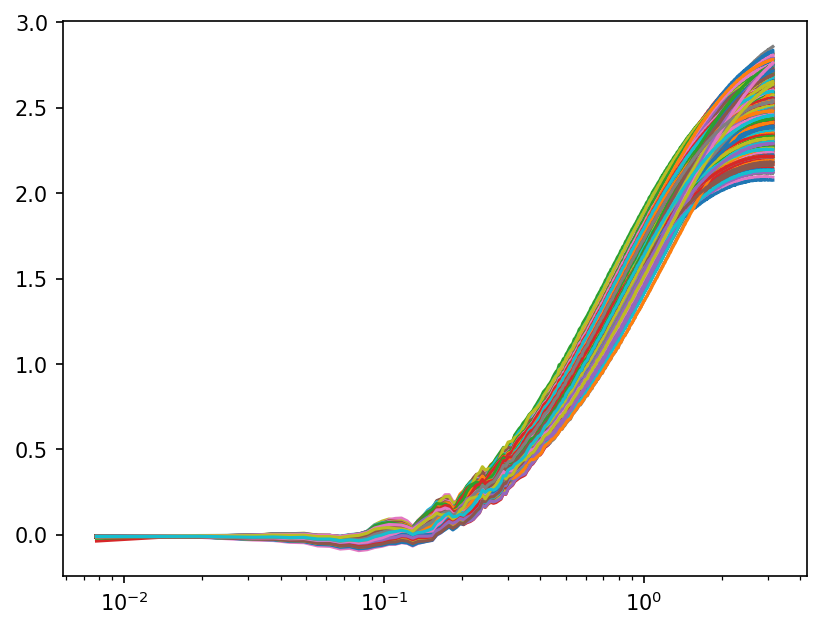

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
#for Init in tqdm(range(14)):
Init =0

redshift=format(zname[Init], '.3f')

print('redshift=',redshift)

#loading ref data 
pk_lin_ref_a=np.array(np.loadtxt('COLA_output/wCDM/500_1/a/output/test_2/pofk_test_2_cb_z'+redshift+'.txt', usecols = 2))[:512]
pk_lin_ref_b=np.array(np.loadtxt('COLA_output/wCDM/500_1/b/output/test_2ph_rev/pofk_test_2ph_rev_cb_z'+redshift+'.txt', usecols = 2))[:512]



pk_nlin_ref_a=np.array(np.loadtxt('COLA_output/wCDM/500_1/a/output/test_2/pofk_test_2_cb_z'+redshift+'.txt', usecols = 1))[:512]
pk_nlin_ref_b=np.array(np.loadtxt('COLA_output/wCDM/500_1/b/output/test_2ph_rev/pofk_test_2ph_rev_cb_z'+redshift+'.txt', usecols = 1))[:512]






kk = np.loadtxt('COLA_output/wCDM/500_1/a/output/test_2/pofk_test_2_cb_z'+redshift+'.txt', usecols = 0)[:512]






#loading train data
pk_lin_data_a =[]
pk_lin_data_b =[]

pk_nlin_data_a = []
pk_nlin_data_b = []


for run in tqdm(range(500)): 
    pk_lin_data_a.append(np.loadtxt('COLA_output/wCDM/500_1/a/output/'+str(run)+'/pofk_run_'+str(run)+'_cb_z'+redshift+'.txt', usecols = 2))
    pk_lin_data_b.append(np.loadtxt('COLA_output/wCDM/500_1/b/output/'+str(run)+'ph_rev/pofk_run_'+str(run)+'ph_rev_cb_z'+redshift+'.txt', usecols = 2))





    pk_nlin_data_a.append(np.loadtxt('COLA_output/wCDM/500_1/a/output/'+str(run)+'/pofk_run_'+str(run)+'_cb_z'+redshift+'.txt', usecols = 1))

    pk_nlin_data_b.append(np.loadtxt('COLA_output/wCDM/500_1/b/output/'+str(run)+'ph_rev/pofk_run_'+str(run)+'ph_rev_cb_z'+redshift+'.txt', usecols = 1))








pk_lin_data_a= np.array(pk_lin_data_a)[:,:512]
pk_lin_data_b= np.array(pk_lin_data_b)[:,:512]

pk_nlin_data_a= np.array(pk_nlin_data_a)[:,:512]
pk_nlin_data_b= np.array(pk_nlin_data_b)[:,:512]

pk_lin_data=(pk_lin_data_a+pk_lin_data_b)/2
pk_nlin_data = (pk_nlin_data_a+pk_nlin_data_b-2)/2
pk_lin_ref=(pk_lin_ref_a+pk_lin_ref_b)/2
pk_nlin_ref=(pk_nlin_ref_a+pk_nlin_ref_b-2)/2



b_case =pk_nlin_data/pk_lin_data  #boost_ee2_ref[0]*R_nlin/R_lin






boost_emu=  np.log(b_case)
scaler_ = CustomScaler()
scaler_.fit(boost_emu)
emu_function_train=boost_emu #np.log(b_case)[:,:500]  #

emu_function_train_norm=scaler_.transform(emu_function_train)

for j in range(0,boost_emu.shape[0],1):
    plt.semilogx(kk[:],boost_emu[j])
plt.show()



#loading train data
pk_lin_data_test_a =[]
pk_lin_data_test_b =[]

pk_nlin_data_test_a = []
pk_nlin_data_test_b = []


for run in tqdm(range(100)): 
    pk_lin_data_test_a.append(np.loadtxt('COLA_output/wCDM/100_1/a/output/'+str(run)+'/pofk_run_'+str(run)+'_cb_z'+redshift+'.txt', usecols = 2))
    pk_lin_data_test_b.append(np.loadtxt('COLA_output/wCDM/100_1/b/output/'+str(run)+'ph_rev/pofk_run_'+str(run)+'ph_rev_cb_z'+redshift+'.txt', usecols = 2))







    pk_nlin_data_test_a.append(np.loadtxt('COLA_output/wCDM/100_1/a/output/'+str(run)+'/pofk_run_'+str(run)+'_cb_z'+redshift+'.txt', usecols = 1))

    pk_nlin_data_test_b.append(np.loadtxt('COLA_output/wCDM/100_1/b/output/'+str(run)+'ph_rev/pofk_run_'+str(run)+'ph_rev_cb_z'+redshift+'.txt', usecols = 1))



pk_lin_data_test_a= np.array(pk_lin_data_test_a)[:,:512]
pk_lin_data_test_b= np.array(pk_lin_data_test_b)[:,:512]

pk_nlin_data_test_a= np.array(pk_nlin_data_test_a)[:,:512]
pk_nlin_data_test_b= np.array(pk_nlin_data_test_b)[:,:512]

pk_lin_data_test=(pk_lin_data_test_a+pk_lin_data_test_b)/2
pk_nlin_data_test = (pk_nlin_data_test_a+pk_nlin_data_test_b-2)/2



b_case_test = pk_nlin_data_test/pk_lin_data_test #boost_ee2_ref[0]*R_nlin_test/R_lin_test



boost_emu_test=  np.log(b_case_test)
emu_function_test=boost_emu_test #np.log(b_case)[:,:500]  #
emu_function_test_norm=scaler_.transform(emu_function_test)
#emu_function_test_norm=(emu_function_test - np.amin(emu_function_train))/(np.amax(emu_function_train) - np.amin(emu_function_train))




def PCA_trans_and_inv(data, n_pc):
    pca = PCA(n_components = n_pc)
    pca.fit(data)
    transformed_data = pca.fit_transform(data)
    reconstructed_data = pca.inverse_transform(transformed_data)
    return reconstructed_data  , transformed_data



def PCA_transinv(data, n_pc, datatrans):
    pca = PCA(n_components = n_pc)
    pca.fit(data)
    reconstructed_data = pca.inverse_transform(datatrans)
    return reconstructed_data 


npca=25

teste,  xsmeared = PCA_trans_and_inv((emu_function_train_norm[:,:]), npca) 

#X= X / (np.linalg.norm(X,axis = 0))
y =   xsmeared #scalery.transform(xsmeared)
#y= y / (np.linalg.norm(y,axis = 0))
Y=y

In [ ]:
from skopt import Optimizer
from skopt.space import Real
from joblib import Parallel, delayed
import numpy as np

# Definir a função objetivo
def objective(params):
    global yteste
    global X
    global y
    global Y
    alpha, l1_ratio = params

    n_samples, n_features = X.shape
    n_targets = y.shape[1]
    n_tasks = y.shape[1]

    #alpha = 1e-6

    #l1_ratio = 0.9

    #alpha = 1e-5 z=0

    #l1_ratio = 0.05 z = 0 



    l1_reg =  alpha *  l1_ratio * n_samples
    l2_reg =  alpha * (1.0 -  l1_ratio) * n_samples

    coef_ = np.zeros(
                    (n_targets, n_features), dtype=X.dtype.type, order="F"
                )

    coef_ = np.asfortranarray(coef_)    #np.random.randn(12, n_features) #np.asfortranarray(coef_) 
    WW = coef_

    max_iter=10
    tol=0.0000001
    gap = tol + 1.0

    XtA = np.zeros((n_features, n_tasks), dtype=X.dtype.type)

    R = np.zeros((n_samples, n_tasks), dtype=X.dtype.type, order='F')

    norm_cols_X = np.zeros(n_features, dtype=X.dtype.type)
    tmp = np.zeros(n_tasks, dtype=X.dtype.type)
    w_ii = np.zeros(n_tasks, dtype=X.dtype.type) 

    norm_cols_X = (np.asarray(X)**2).sum(axis=0)

    R = Y - np.dot(X, WW.T)

    tol = tol * np.linalg.norm(Y, ord='fro') ** 2

    WW = np.asfortranarray(WW ) 
    X = np.asfortranarray(X ) 
    R = np.asfortranarray(R ) 
    norm_cols_X = np.asfortranarray(norm_cols_X) 


    for i in range(501): 


        ElNetFortran.fit(n_features, 1,l1_reg,l2_reg, 
        WW ,
        X,R,norm_cols_X)

    testes=(yteste@WW.T)
    Xboost_iselfevals = PCA_transinv(emu_function_train_norm,npca, testes)

    Xboost_iselfevals_rescaled= scaler_.inverse_transform(Xboost_iselfevals)
    
    
    

 
    return mean_squared_error(np.exp(emu_function_test),np.exp( Xboost_iselfevals_rescaled ))

# Definir o espaço de busca de hiperparâmetros
space = [Real(1e-5, 1e-3, name='alpha'), Real(0.6, 1.0, name='l1_ratio')]

# Inicializar o otimizador
optimizer = Optimizer(space, base_estimator='gp', n_initial_points=10, acq_func='EI')

# Avaliar os pontos iniciais
x0 = optimizer.ask(n_points=10)
y0 = Parallel(n_jobs=10, verbose=1)(delayed(objective)(x) for x in x0)
optimizer.tell(x0, y0)

# Otimização iterativa
for i in tqdm(range(1)):
    x__ = optimizer.ask(n_points=36*3)  # Obter 4 pontos para avaliação paralela
    y__ = Parallel(n_jobs=-1, verbose=1)(delayed(objective)(v) for v in x__)  # Avaliar os pontos em paralelo
    optimizer.tell(x__, y__)  # Atualizar o otimizador com os novos pontos avaliados

best_index = np.argmin(optimizer.yi)
best_params = optimizer.Xi[best_index]
best_value = optimizer.yi[best_index]

print(f"Melhores hiperparâmetros: alpha={best_params[0]}, l1_ratio={best_params[1]}")
print(f"Valor da função objetivo para os melhores hiperparâmetros: {best_value}")


n_samples, n_features = X.shape
n_targets = y.shape[1]
n_tasks = y.shape[1]

alpha=best_params[0]
l1_ratio=best_params[1]

  0%|          | 0/501 [00:00<?, ?it/s]

7.028728289724769e-05 teste error
salvando pcas and scaler
7.028731378448063e-05 teste error mine


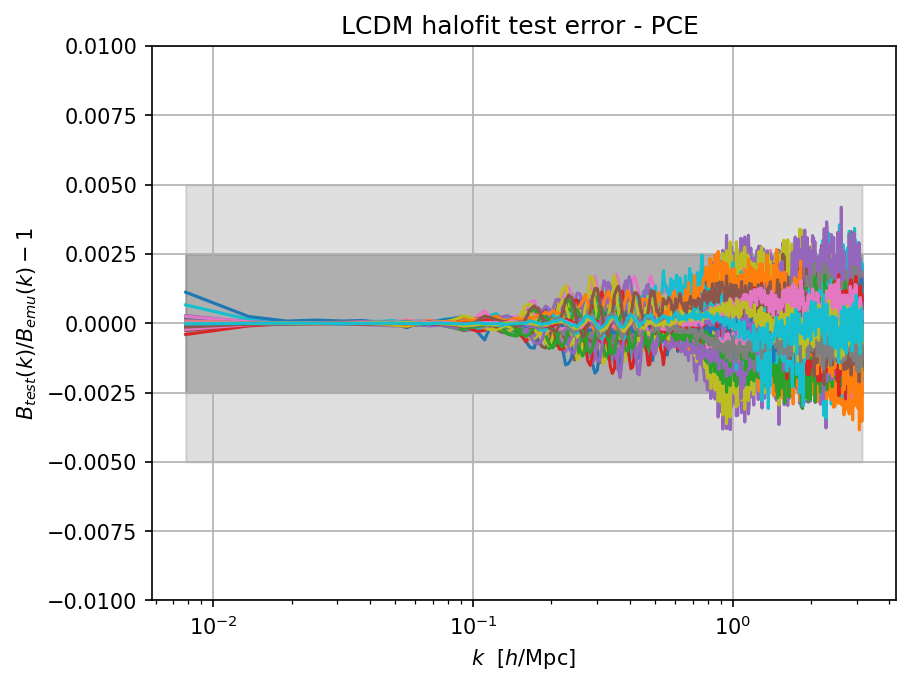

In [34]:
l1_reg =  alpha *  l1_ratio * n_samples
l2_reg =  alpha * (1.0 -  l1_ratio) * n_samples

coef_ = np.zeros(
            (n_targets, n_features), dtype=X.dtype.type, order="F"
        )

coef_ =np.asfortranarray(coef_)    # np.asfortranarray(np.random.randn(npca, n_features)) # np.asfortranarray(coef_)    #np.random.randn(npca, n_features) #np.asfortranarray(coef_) 
W = coef_

max_iter=10
tol=0.0000001
gap = tol + 1.0

XtA = np.zeros((n_features, n_tasks), dtype=X.dtype.type)

R = np.zeros((n_samples, n_tasks), dtype=X.dtype.type, order='F')

norm_cols_X = np.zeros(n_features, dtype=X.dtype.type)
tmp = np.zeros(n_tasks, dtype=X.dtype.type)
w_ii = np.zeros(n_tasks, dtype=X.dtype.type) 

norm_cols_X = (np.asarray(X)**2).sum(axis=0)

R = Y - np.dot(X, W.T)

tol = tol * np.linalg.norm(Y, ord='fro') ** 2

W = np.asfortranarray(W ) 
X = np.asfortranarray(X ) 
R = np.asfortranarray(R ) 
norm_cols_X = np.asfortranarray(norm_cols_X) 

mse_=[]
for i in tqdm(range(501)): #379 #590 #540


    ElNetFortran.fit(n_features, 1,l1_reg,l2_reg, 
    W ,
    X,R,norm_cols_X)
    
    
Xboost_iselfevals = PCA_transinv(emu_function_train_norm[:,:],npca,(yteste@W.T) )

Xboost_iselfevals_rescaled = scaler_.inverse_transform(Xboost_iselfevals)

print(mean_squared_error(np.exp(emu_function_test[:,:] ), np.exp(Xboost_iselfevals_rescaled)), 'teste error' )    
pca_ = PCA(n_components = npca)
pca_.fit(emu_function_train_norm)

Wtrans=W.T
A= pca_.components_*scaler_.std
b =pca_.mean_*scaler_.std  + scaler_.mean

Wtrans_=np.array([Wtrans])
A_ = np.array([A])
b_=  np.array([b])





print('salvando pcas and scaler') 


yteste_ = np.array(yteste)





Xboost_iselfevals_rescaled = pce_.predict_one_cosmo( yteste_ ,  Wtrans_,   A_,   b_)[0]        
print(mean_squared_error(np.exp(emu_function_test[:,:] ), np.exp(Xboost_iselfevals_rescaled)), 'teste error', 'mine' )


for j in range(0,emu_function_test.shape[0],1):
    plt.semilogx(kk[:],(np.exp(Xboost_iselfevals_rescaled[j])/np.exp(emu_function_test[j,:] ))  - 1  , label="ultimo lhs")


percent = 0.0025
plt.fill_between(kk, -percent, percent, color = 'gray', alpha = 0.50, label = f'${percent}\%$')

percent = 0.005
plt.fill_between(kk, -percent, percent, color = 'gray', alpha = 0.25, label = f'${percent}\%$')

plt.grid()
plt.ylim(-0.01,0.01)
#plt.yticks(np.arange(-0.005, 0.01, 0.005))  # np.arange(start, end, step)
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$B_{test}(k)/B_{emu}(k) - 1 \,\,\,\,$')
plt.title(r'LCDM halofit test error - PCE ')
plt.show()    

Y_= (yteste@W.T)
X_= (X@W.T)    

In [35]:
val_loss_threshold = mean_squared_error(np.exp(emu_function_test[:,:] ), np.exp(Xboost_iselfevals_rescaled))*0.50
redshift_2=format(zname[Init-1], '.3f')
first_try = 0 
while True:  # Loop externo
    concluido = False
    best_val_loss = float('inf')

    while not concluido:
        try:
            # Criação do modelo
            model = Net(npca, npca, 128).to(device)
                # Supondo que o arquivo esteja salvo em 'melhor_modelo.pth'
            if first_try == 0 and zname[Init] != 0.000:

                model.load_state_dict(torch.load(f'MODEL_Z{redshift_2}.pth'))
                # Coloque o modelo em modo de avaliação
                model.train()
            criterion = nn.MSELoss()
            optimizer = torch.optim.LBFGS(model.parameters(), lr=0.05)
           # print(model)

            inputs = torch.tensor(X_, dtype=torch.float64).to(device)
            targets = torch.tensor(xsmeared, dtype=torch.float64).to(device)
            Y_target = torch.tensor(Y_, dtype=torch.float64).to(device)
            
            
            
            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                return loss

            first_loss= closure()    
            print(first_loss)
            if first_loss >0.2:
                raise ValueError(f"Valor de inicial da loss muito alto: {first_loss}")
            first_try = 1

            loss = optimizer.step(closure)
            if loss > 100:
                raise ValueError(f"Valor de val_loss muito alto: {val_loss}")
            loss= 0 
            for i in tqdm(range(1500)):
                test_loss=loss
                loss = optimizer.step(closure)
                
                predictions = model(Y_target).cpu().detach().numpy()

                Xboost_iselfevals = PCA_transinv(emu_function_train_norm, npca, predictions)
                Xboost_iselfevals_rescaled = scaler_.inverse_transform(Xboost_iselfevals)

                val_loss = mean_squared_error(np.exp(emu_function_test), np.exp(Xboost_iselfevals_rescaled))

                print(f'Epoch: {i}, Loss: {loss.item()}, Val_Loss: {val_loss}')

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), f'MODEL_Z{redshift}.pth')
                if loss > 100:
                    raise ValueError(f"Valor de val_loss muito alto: {val_loss}")
                if torch.abs(loss - test_loss) < 0.00000001:
                    break                    

            concluido = True

        except ValueError as e:
            print(f"Ocorreu um erro, reiniciando o treinamento: {e}")

    if best_val_loss < val_loss_threshold:
        break  # Sai do loop externo se o critério for atendido
    else:
        print(f"Reiniciando o treinamento, best_val_loss {best_val_loss} é maior que o limite {val_loss_threshold}")   
    
   
 

tensor(0.1210, grad_fn=<MseLossBackward0>)


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.016248999760494598, Val_Loss: 0.0001751895190332792
Epoch: 1, Loss: 0.005175238790786788, Val_Loss: 9.502502616159762e-05
Epoch: 2, Loss: 0.002032747094201804, Val_Loss: 7.663084416424185e-05
Epoch: 3, Loss: 0.001119118111350116, Val_Loss: 6.983620121543193e-05
Epoch: 4, Loss: 0.0007729152232591356, Val_Loss: 6.781870789700666e-05
Epoch: 5, Loss: 0.0006261618755231077, Val_Loss: 6.66097573856824e-05
Epoch: 6, Loss: 0.0005520390033416914, Val_Loss: 6.466952916111987e-05
Epoch: 7, Loss: 0.0004965043202114523, Val_Loss: 6.278228327350093e-05
Epoch: 8, Loss: 0.00046247911736627855, Val_Loss: 6.145958658430685e-05
Epoch: 9, Loss: 0.00044696466189905374, Val_Loss: 5.938587490942972e-05
Epoch: 10, Loss: 0.00042745911352935593, Val_Loss: 5.6604111861339245e-05
Epoch: 11, Loss: 0.00040494242559605367, Val_Loss: 5.479364244581127e-05
Epoch: 12, Loss: 0.00038930040159887333, Val_Loss: 5.369832939783552e-05
Epoch: 13, Loss: 0.00037685994342206454, Val_Loss: 5.236964990456454e-05


KeyboardInterrupt: 

2.897229879430469e-05


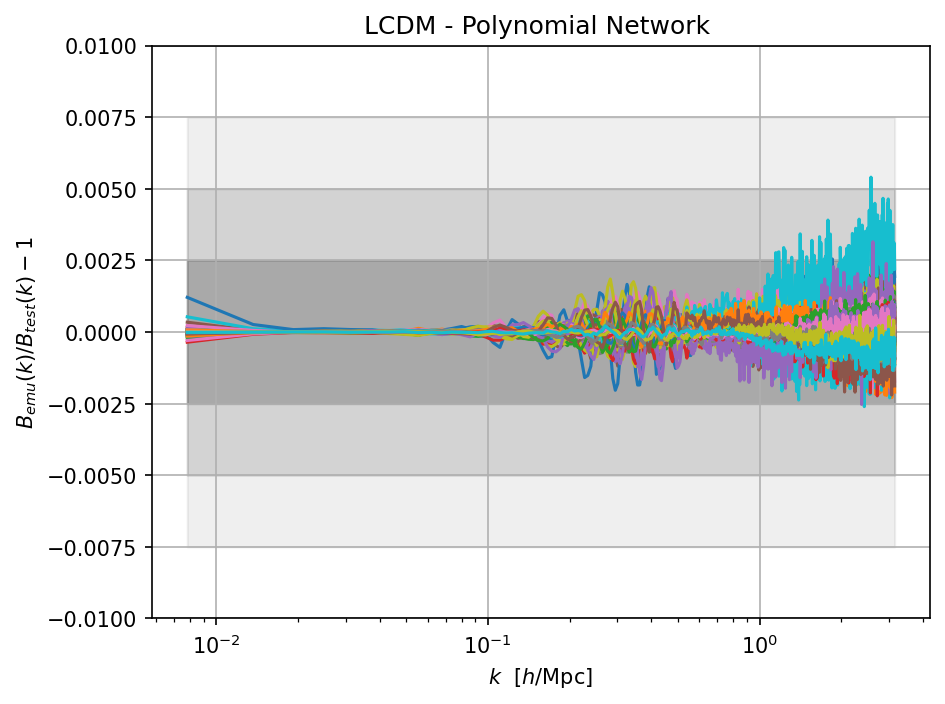

In [36]:
model.load_state_dict(torch.load(f'MODEL_Z{redshift}.pth'))

predictions =model(torch.Tensor(Y_)).cpu().detach().numpy()

Xboost_iselfevals = PCA_transinv(emu_function_train_norm,npca, (predictions))

Xboost_iselfevals_rescaled= scaler_.inverse_transform(Xboost_iselfevals)


print(mean_squared_error(np.exp(emu_function_test ), np.exp(Xboost_iselfevals_rescaled)) )


for j in range(0,emu_function_test.shape[0],1):
    plt.semilogx(kk[:],(np.exp(Xboost_iselfevals_rescaled[j])/np.exp(emu_function_test[j,:] ))  - 1  , label="ultimo lhs")
    
percent = 0.0025
plt.fill_between(kk, -percent, percent, color = 'gray', alpha = 0.50, label = f'${percent}\%$')

percent = 0.005
plt.fill_between(kk, -percent, percent, color = 'gray', alpha = 0.25, label = f'${percent}\%$')
percent = 0.0075
plt.fill_between(kk, -percent, percent, color = 'gray', alpha = 0.125, label = f'${percent}\%$')
plt.grid()
plt.ylim(-0.01,0.01)
#plt.yticks(np.arange(-0.005, 0.01, 0.005))  # np.arange(start, end, step)
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$B_{emu}(k)/B_{test}(k) - 1 \,\,\,\,$')
plt.title(r'LCDM - Polynomial Network ')
plt.tight_layout()
#plt.savefig('Polynomial_Network.pdf')  
plt.show() 




 